# Explaining Feature Importance by example of a Random Forest

In [1]:
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
from sklearn.base import clone 
from sklearn.metrics import r2_score
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from treeinterpreter import treeinterpreter as ti, utils

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('max_columns', None)
pd.set_option('precision', 3)

sns.set_style("whitegrid")
sns.set(rc = {'figure.figsize':(15, 10)})

In [2]:
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 20)

In [3]:
boston = load_boston()
# print(boston.DESCR)

In [4]:
y = boston.target
X = pd.DataFrame(boston.data, columns = boston.feature_names)

# Add random noise column for reference
np.random.seed(seed = 42)
X['random'] = np.random.random(size = len(X))
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.8, random_state = 42)

### Benchmark model

In [5]:
rf = RandomForestRegressor(
    n_estimators = 100,
    n_jobs = -1,
    oob_score = True,
    bootstrap = True,
    random_state = 42
)

rf.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, oob_score=True, random_state=42)

In [6]:
print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(
    rf.score(X_train, y_train), rf.oob_score_, rf.score(X_valid, y_valid)))

R^2 Training Score: 0.93 
OOB Score: 0.57 
R^2 Validation Score: 0.75


# Overall feature importances

### Using default sklearn

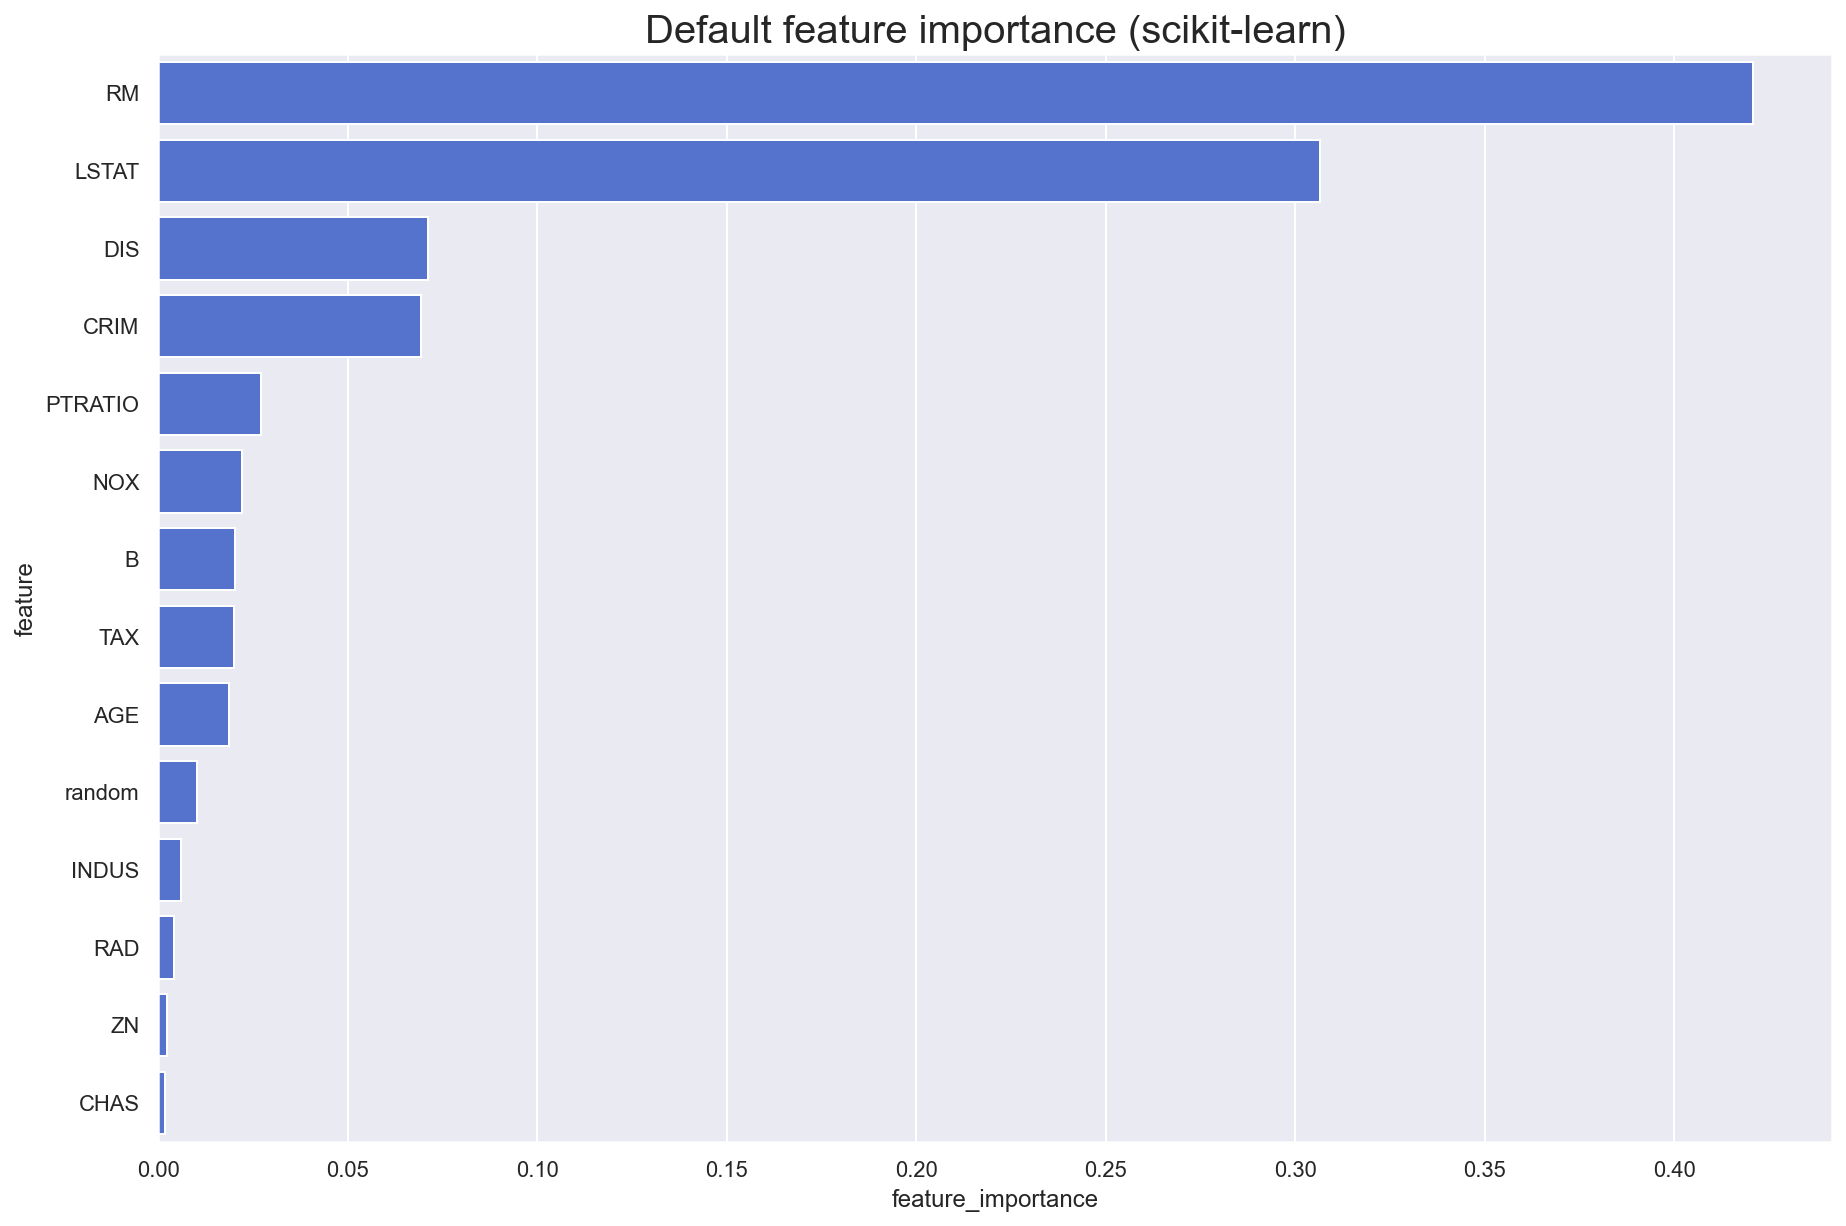

In [7]:
base_imp = imp_df(X_train.columns, rf.feature_importances_)
var_imp_plot(base_imp, 'Default feature importance (scikit-learn)')

### Drop column feature importance

In [8]:
def drop_col_feat_imp(model, X_train, y_train, random_state = 42):
    
    # clone the model to have the exact same specification as the one initially trained
    model_clone = clone(model)
    # set random_state for comparability
    model_clone.random_state = random_state
    # training and scoring the benchmark model
    model_clone.fit(X_train, y_train)
    benchmark_score = model_clone.score(X_train, y_train)
    # list for storing feature importances
    importances = []
    
    # iterating over all columns and storing feature importance (difference between benchmark and new model)
    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col, axis = 1), y_train)
        drop_col_score = model_clone.score(X_train.drop(col, axis = 1), y_train)
        importances.append(benchmark_score - drop_col_score)
    
    importances_df = imp_df(X_train.columns, importances)
    return importances_df

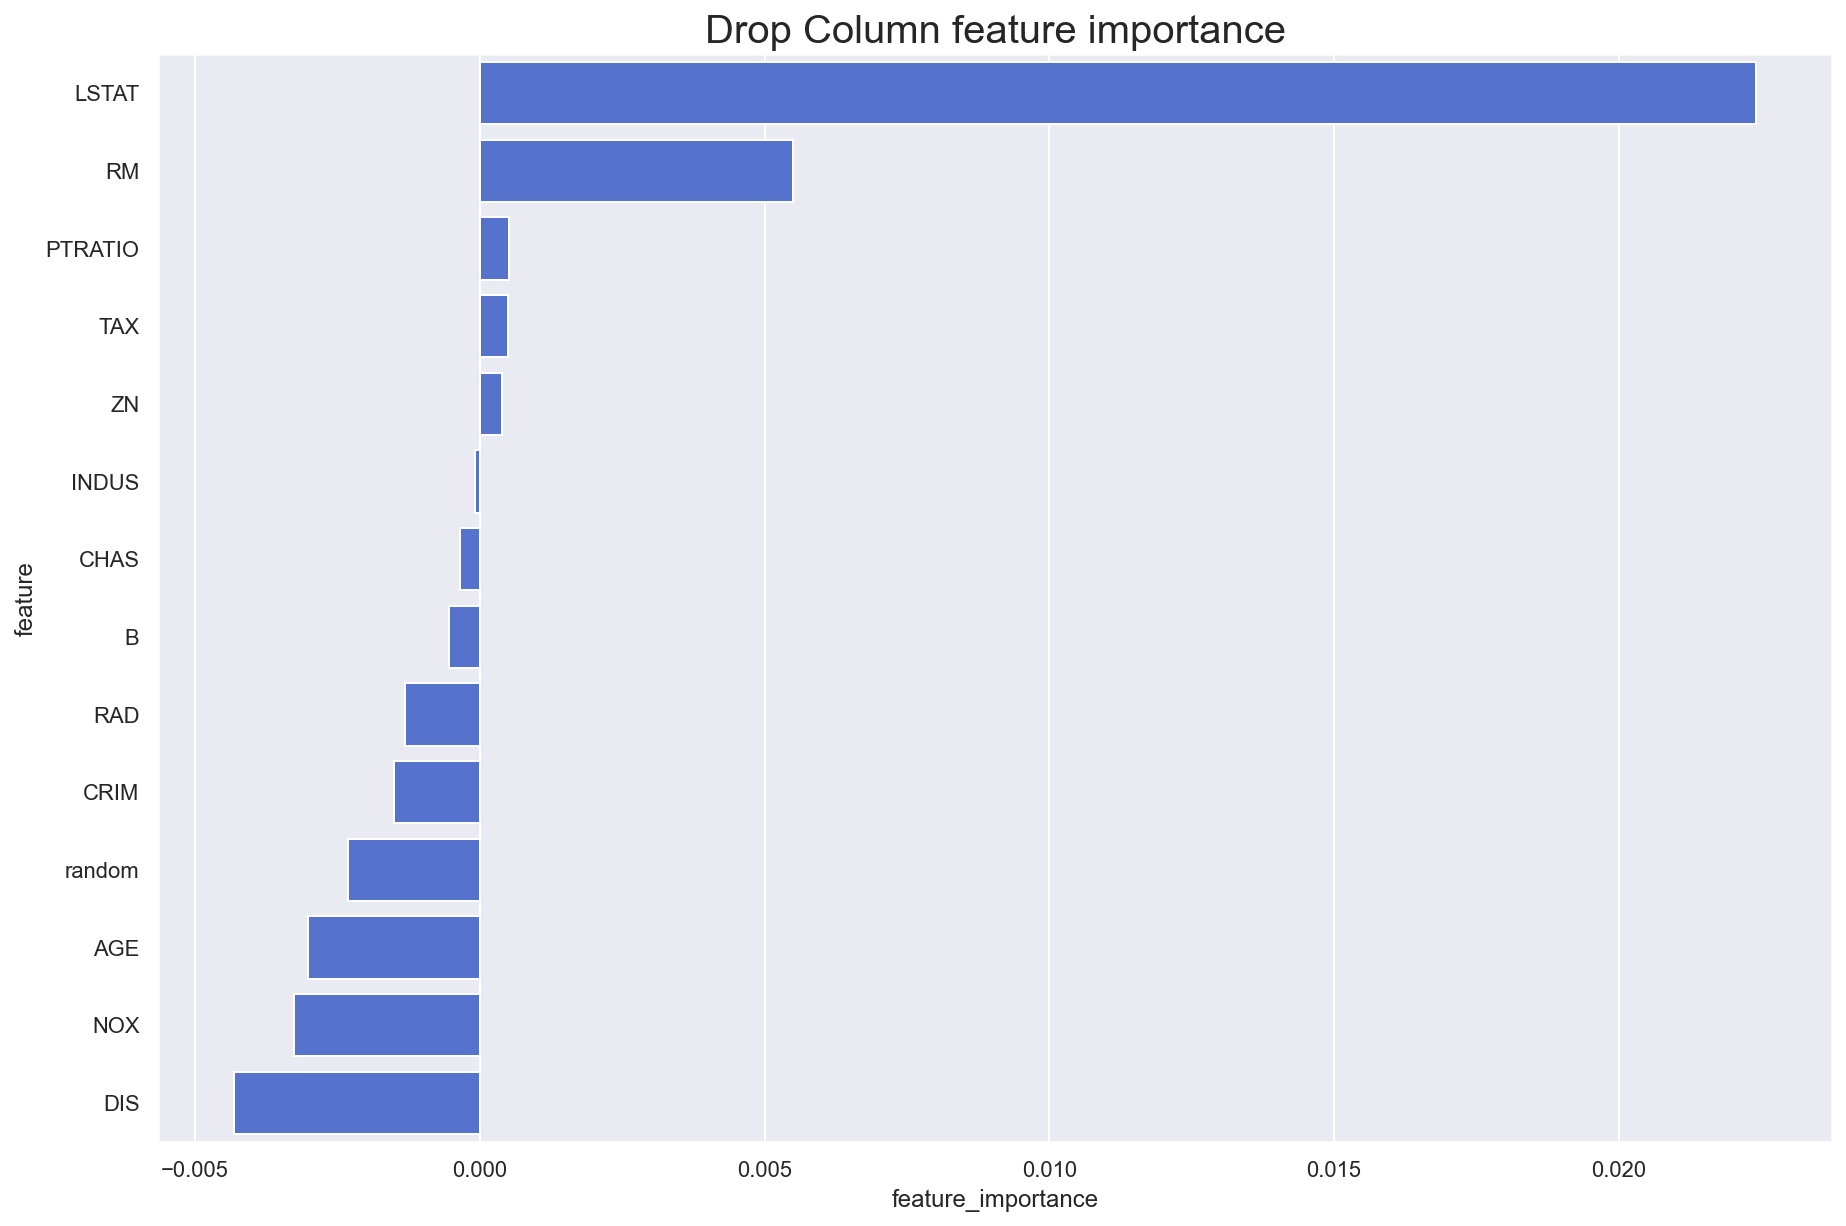

In [9]:
drop_imp = drop_col_feat_imp(rf, X_train, y_train)
var_imp_plot(drop_imp, 'Drop Column feature importance')

# Observation level feature importance

### Treeinterpreter

In [10]:
def make_inference_df(X_df, model):
    df = X_df.copy(deep=True)
    df["TAR_pred"] = model.predict(X_df)
    
    prediction, bias, contributions = ti.predict(model, X_df)
    
    f_imp = lambda name: name + "_imp"
    imp_cols = [f_imp(c) for c in X_df.columns.values.tolist()]
    df[imp_cols] = contributions
    return df, imp_cols

In [11]:
hdf, imp_cols = make_inference_df(X_df=X_train, model=rf)

In [12]:
hdf.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,random,TAR_pred,CRIM_imp,ZN_imp,INDUS_imp,CHAS_imp,NOX_imp,RM_imp,AGE_imp,DIS_imp,RAD_imp,TAX_imp,PTRATIO_imp,B_imp,LSTAT_imp,random_imp
295,0.129,0.0,13.92,0.0,0.437,6.678,31.1,5.960,4.0,289.0,16.0,396.90,6.27,0.522,27.623,0.091,-0.092,-0.022,9.444e-04,-0.141,0.818,0.176,-0.244,-0.068,-0.234,0.810,-0.205,4.133,0.055
462,6.655,0.0,18.10,0.0,0.713,6.317,83.0,2.734,24.0,666.0,20.2,396.90,13.99,0.746,20.017,0.289,0.000,0.036,-7.773e-04,-0.138,-1.979,-0.286,-0.021,0.104,-0.034,-0.532,-0.001,-0.076,0.111
251,0.214,22.0,5.86,0.0,0.431,6.438,8.9,7.397,7.0,330.0,19.1,377.07,3.59,0.385,24.819,-0.192,-0.020,0.044,-1.715e-02,-0.008,-3.313,0.470,-0.330,0.078,-0.262,0.044,0.258,5.518,0.005
494,0.280,0.0,9.69,0.0,0.585,5.926,42.6,2.382,6.0,391.0,19.2,396.90,13.59,0.464,23.111,0.342,0.008,0.051,-4.174e-03,0.073,-1.912,1.030,0.330,0.158,0.082,0.290,0.062,-0.239,0.295
464,7.839,0.0,18.10,0.0,0.655,6.209,65.4,2.963,24.0,666.0,20.2,396.90,13.22,0.962,20.698,-0.097,0.009,0.045,-6.901e-03,-0.017,-1.861,-0.011,0.073,0.119,-0.009,-0.498,-0.021,0.173,0.257


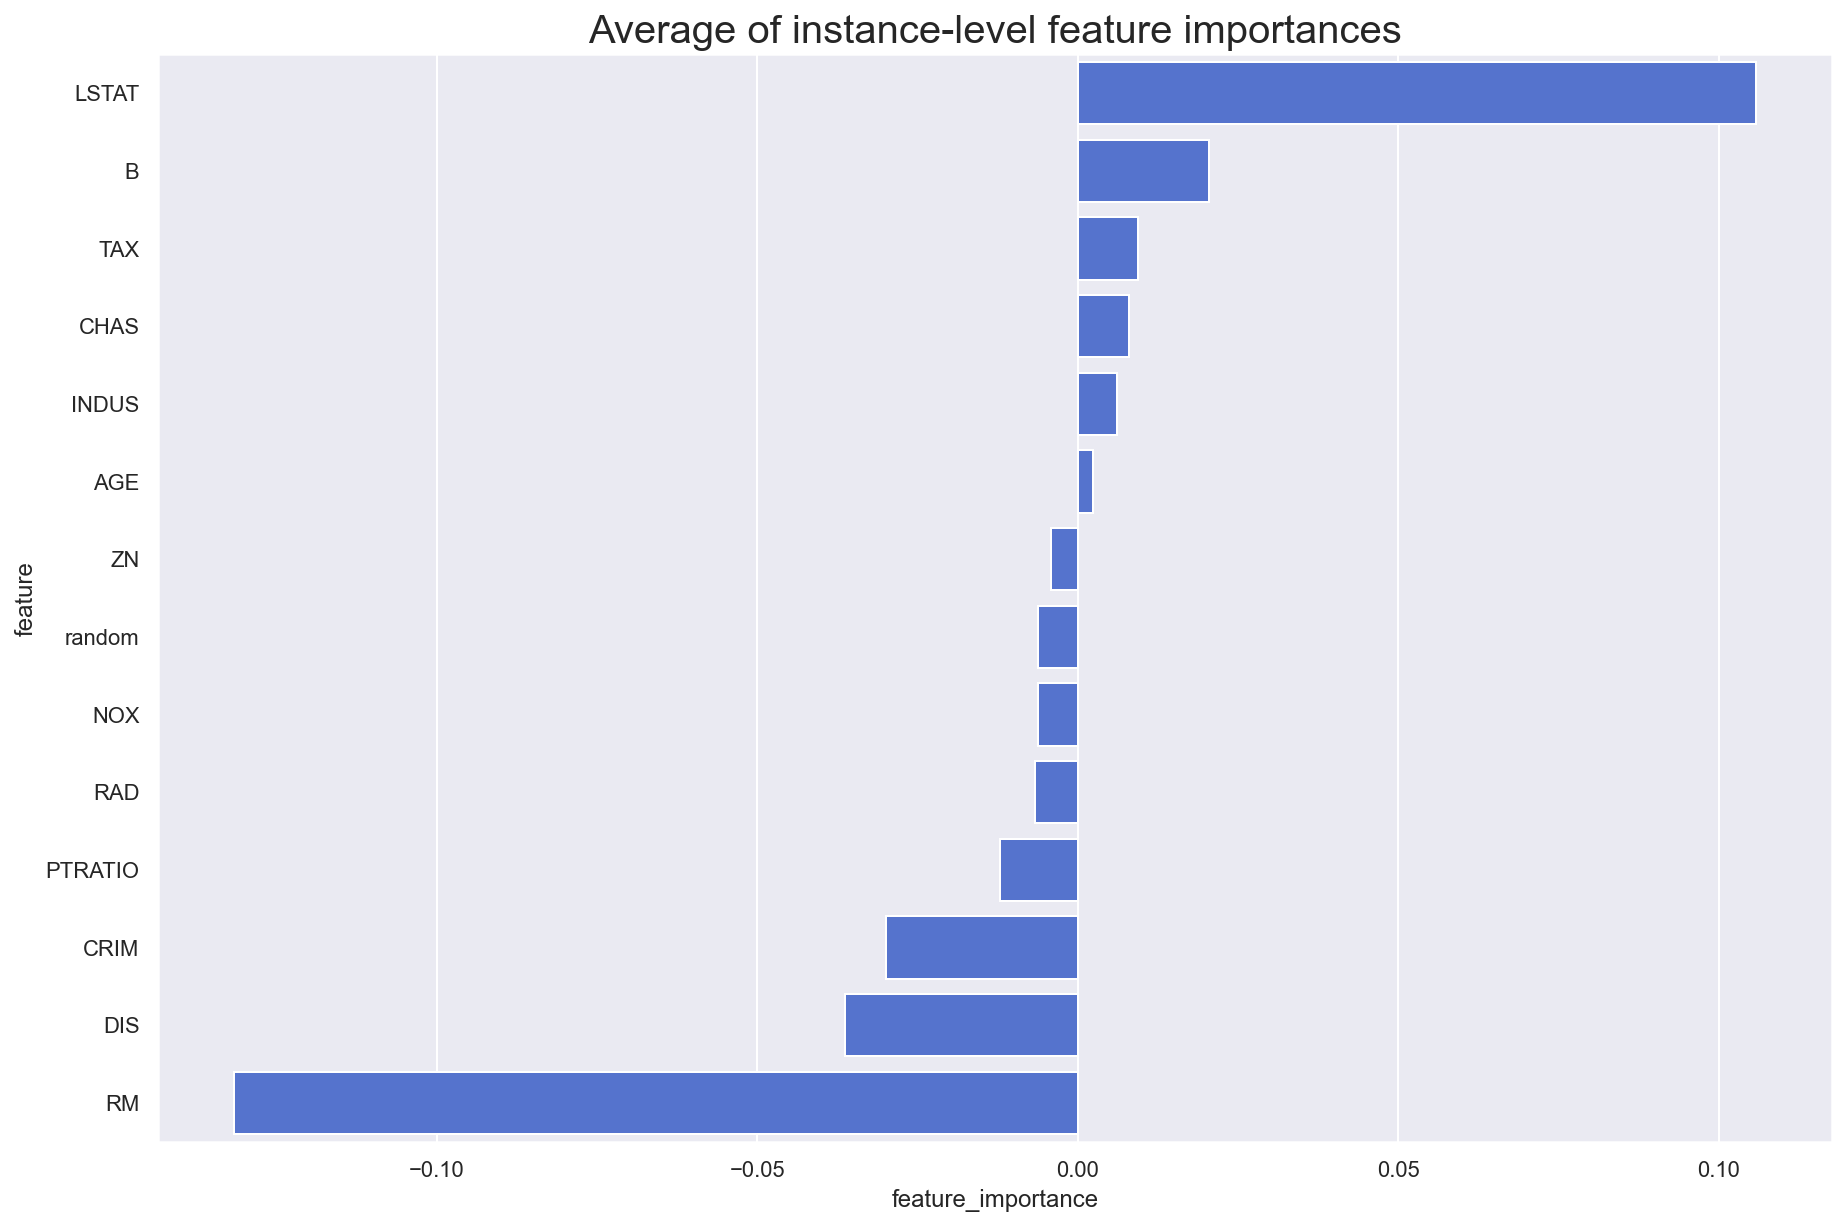

In [13]:
avg_imp = imp_df(X_train.columns, hdf.loc[:,imp_cols].mean().values)
var_imp_plot(avg_imp, 'Average of instance-level feature importances')